# MNIST Digit Classifier

## About
Classify handwritten digits using a Convolutional Neural Network with Tensorflow mostly based on the [official TF CNN Tutorial](https://www.tensorflow.org/tutorials/estimators/cnn).



In [1]:
# Imports
import numpy as np
import tensorflow as tf



D:\Stuff\Installs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Defining model
def cnn_model_fn(features, labels, mode):
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



In [3]:
# Load training and eval data
((train_data, train_labels), (eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()

train_data = train_data/np.float32(255)
train_labels = train_labels.astype(np.int32)

eval_data = eval_data/np.float32(255)
eval_labels = eval_labels.astype(np.int32)



Sample image label:  7


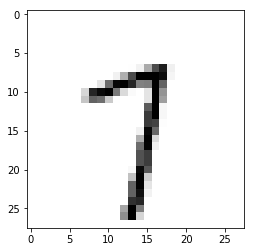

In [4]:
# Check out sample image
import matplotlib.pyplot as plt
%matplotlib inline

image_idx = 42
print('Sample image label: ', train_labels[image_idx])
plt.imshow(train_data[image_idx], cmap='Greys');



In [5]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="./model")



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B8C5765C88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}

logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)



In [7]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

# train one step and display the probabilties
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model\model.ckpt-1001
Instructions for updating:
Use standard file 

INFO:tensorflow:loss = 1.9896094, step = 1001
INFO:tensorflow:Saving checkpoints for 1002 into ./model\model.ckpt.
INFO:tensorflow:Loss for final step: 1.9896094.


In [8]:
mnist_classifier.train(input_fn=train_input_fn, steps=1000)



INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model\model.ckpt-1002
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1002 into ./model\model.ckpt.
INFO:tensorflow:loss = 1.9768846, step = 1002
INFO:tensorflow:global_step/sec: 145.738
INFO:tensorflow:loss = 1.792494, step = 1102 (0.687 sec)
INFO:tensorflow:global_step/sec: 161.722
INFO:tensorflow:loss = 1.6198645, step = 1202 (0.617 sec)
INFO:tensorflow:global_step/sec: 162.245
INFO:tensorflow:loss = 1.4896084, step = 1302 (0.616 sec)
INFO:tensorflow:global_step/sec: 160.685
INFO:tensorflow:loss = 1.3052058, step = 1402 (0.622 sec)
INFO:tensorflow:global_step/sec: 158.903
INFO:tensorflow:loss = 1.2581234, step = 1502 (0.629 sec)
INFO:tensorflow:global_step/sec: 163.037
INFO:tensorflow:loss = 1.0832466, step = 1602 (

In [9]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)



INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-15T14:36:50Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model\model.ckpt-2002
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-15-14:36:51
INFO:tensorflow:Saving dict for global step 2002: accuracy = 0.8531, global_step = 2002, loss = 0.63587254
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2002: ./model\model.ckpt-2002
{'accuracy': 0.8531, 'loss': 0.63587254, 'global_step': 2002}
